## Data Extraction

In [ ]:
import polars as pl

In [ ]:
df_raw = pl.read_csv(
    "/content/sentiment-analysis.csv",
    has_header=False,
    new_columns=["raw"]
)

In [ ]:
df = (
    df_raw.with_columns(
        pl.col("raw").str.split(",").alias("parts")
    ).filter(
        pl.col("parts").list.len() >= 7
    ).with_columns([
        # keep Text (everything except last 6)
        pl.col("parts").list.slice(0, -6).list.join(",").alias("Text"),
        # Last 6 parts (in order)
        pl.col("parts").list.get(-6).alias("Sentiment"),
        pl.col("parts").list.get(-5).alias("Source"),
        pl.col("parts").list.get(-4).alias("Date/Time"),
        pl.col("parts").list.get(-3).alias("User ID"),
        pl.col("parts").list.get(-2).alias("Location"),
        pl.col("parts").list.get(-1).alias("Confidence Score"),
    ]).select([
        "Text", "Sentiment", "Source", "Date/Time",
        "User ID", "Location", "Confidence Score"
    ])
    .with_columns(pl.all().str.strip_chars())  # Clean whitespace
)

In [ ]:
df.sample(5)

## Data Cleaning

In [ ]:
df_clean = df.clone()

text_cols = ["Text", "Sentiment", "Source", "User ID", "Location"]
df_clean = df_clean.with_columns([
    pl.col(col)
    .str.strip_chars()
    .str.strip_chars('"')
    .str.strip_chars('"')
    .str.to_lowercase()
    .str.replace_all(r"[^a-z0-9\s]", "", literal=False)
    .str.replace_all(r"\s+", " ", literal=False)
    .str.strip_chars()
    for col in text_cols
])

structured_cols = ["Confidence Score", "Date/Time"]
df_clean = df_clean.with_columns([
    pl.col(col)
    .str.strip_chars()
    .str.strip_chars('"')
    .str.strip_chars('"')
    for col in structured_cols
])

df_clean = df_clean.filter(
    pl.col("Sentiment").is_in(["positive", "negative"])
)



In [ ]:
print(df_clean.sample(5))

In [ ]:
# Check unique values to inspect format
print("Sample Confidence Scores:")
print(df.select("Confidence Score").head(5))

print("\nSample Date/Time:")
print(df.select("Date/Time").head(5))



Sample Confidence Scores:
shape: (5, 1)
┌──────────────────┐
│ Confidence Score │
│ ---              │
│ str              │
╞══════════════════╡
│ Confidence Score │
│ 0.85             │
│ 0.65             │
│ 0.92             │
│ 0.78             │
└──────────────────┘

Sample Date/Time:
shape: (5, 1)
┌─────────────────────┐
│ Date/Time           │
│ ---                 │
│ str                 │
╞═════════════════════╡
│ Date/Time           │
│ 2023-06-15 09:23:14 │
│ 2023-06-15 11:45:32 │
│ 2023-06-15 14:10:22 │
│ 2023-06-15 17:35:11 │
└─────────────────────┘


In [ ]:
# Data Type Conversion

df_clean = df_clean.with_columns([
    pl.col("Confidence Score").cast(pl.Float64, strict=False),
    pl.col("Date/Time").str.to_datetime(strict=False)
])

# Find rows where either Confidence Score or Date/Time is null
invalid_rows = df_clean.filter(
    pl.col("Confidence Score").is_null() | pl.col("Date/Time").is_null()
)

print("Invalid row(s) (to be removed):")
print(invalid_rows)

# Remove them
df_clean = df_clean.filter(
    pl.col("Confidence Score").is_not_null() & pl.col("Date/Time").is_not_null()
)

print(f"\nRemaining rows after removal: {df_clean.shape[0]}")

Invalid row(s) (to be removed):
shape: (0, 7)
┌──────┬───────────┬────────┬──────────────┬─────────┬──────────┬──────────────────┐
│ Text ┆ Sentiment ┆ Source ┆ Date/Time    ┆ User ID ┆ Location ┆ Confidence Score │
│ ---  ┆ ---       ┆ ---    ┆ ---          ┆ ---     ┆ ---      ┆ ---              │
│ str  ┆ str       ┆ str    ┆ datetime[μs] ┆ str     ┆ str      ┆ f64              │
╞══════╪═══════════╪════════╪══════════════╪═════════╪══════════╪══════════════════╡
└──────┴───────────┴────────┴──────────────┴─────────┴──────────┴──────────────────┘

Remaining rows after removal: 96


## EDA

In [ ]:

print("\nSentiment distribution:")
sentiment_counts = df_clean.group_by("Sentiment").len().sort("len", descending=True)
print(sentiment_counts)


df_with_len = df_clean.with_columns(
    pl.col("Text").str.len_chars().alias("text_len")
)
print("\nText length stats (characters):")
print(df_with_len.select("text_len").describe())


Sentiment distribution:
shape: (2, 2)
┌───────────┬─────┐
│ Sentiment ┆ len │
│ ---       ┆ --- │
│ str       ┆ u32 │
╞═══════════╪═════╡
│ positive  ┆ 53  │
│ negative  ┆ 43  │
└───────────┴─────┘

Text length stats (characters):
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ text_len  │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 96.0      │
│ null_count ┆ 0.0       │
│ mean       ┆ 117.28125 │
│ std        ┆ 17.070568 │
│ min        ┆ 73.0      │
│ 25%        ┆ 108.0     │
│ 50%        ┆ 120.0     │
│ 75%        ┆ 128.0     │
│ max        ┆ 152.0     │
└────────────┴───────────┘


## Encoding

In [ ]:
label_map = {"positive": 0, "negative": 1}

# Encode
df_final = df_clean.with_columns(
    pl.col("Sentiment").replace(label_map).cast(pl.Int32).alias("label")
)

print("\nLabel encoding Sample:")
print(df_final.select("Sentiment", "label").sample(5))



Label encoding Sample:
shape: (5, 2)
┌───────────┬───────┐
│ Sentiment ┆ label │
│ ---       ┆ ---   │
│ str       ┆ i32   │
╞═══════════╪═══════╡
│ positive  ┆ 0     │
│ positive  ┆ 0     │
│ positive  ┆ 0     │
│ negative  ┆ 1     │
│ positive  ┆ 0     │
└───────────┴───────┘


In [ ]:
label_map = {"positive": 0, "negative": 1}
num_labels = 2

df_final = df_clean.with_columns(
    pl.col("Sentiment").replace(label_map).cast(pl.Int32).alias("label")
)


## Dataset Preparation

In [ ]:
from sklearn.model_selection import train_test_split

df_pd = df_final.select(["Text", "label"]).to_pandas()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_pd["Text"],
    df_pd["label"],
    test_size=0.2,
    stratify=df_pd["label"],
    random_state=42
)

print(f"Train: {len(train_texts)} samples")
print(f"Val:   {len(val_texts)} samples")

Train: 76 samples
Val:   20 samples


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    'google-bert/bert-base-uncased',
    use_fast=True,
    local_files_only=False
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
test = tokenizer("Hello, this is a test.", return_tensors="pt")
print(test["input_ids"].shape)

torch.Size([1, 9])


In [ ]:
# Tokenize function
def tokenize(texts):
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )

# Tokenize train and validation sets
train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

In [ ]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

## Modeling

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load pre-trained BERT for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    "google-bert/bert-base-uncased",
    num_labels=2
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert-sentiment",
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average="weighted")
    }

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Start fine-tuning
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.650970,0.550000,0.390323
2,No log,0.494712,0.850000,0.848872
3,No log,0.331986,0.850000,0.850376
4,No log,0.222503,0.950000,0.950125
5,No log,0.008139,1.000000,1.000000
6,No log,0.001962,1.000000,1.000000
7,No log,0.000900,1.000000,1.000000
8,No log,0.000544,1.000000,1.000000
9,No log,0.000417,1.000000,1.000000
10,No log,0.000356,1.000000,1.000000


TrainOutput(global_step=150, training_loss=0.1262710189819336, metrics={'train_runtime': 367.923, 'train_samples_per_second': 3.098, 'train_steps_per_second': 0.408, 'total_flos': 22261661949600.0, 'train_loss': 0.1262710189819336, 'epoch': 15.0})

In [ ]:
eval_results = trainer.evaluate()

print("Final Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

Final Evaluation Results:
eval_loss: 0.0081
eval_accuracy: 1.0000
eval_f1: 1.0000
eval_runtime: 0.1474
eval_samples_per_second: 135.6830
eval_steps_per_second: 13.5680
epoch: 15.0000


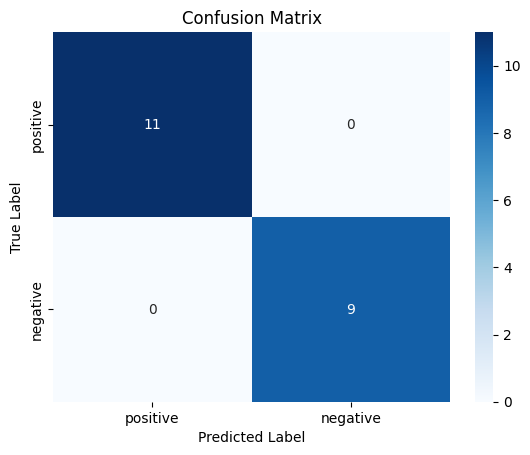

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
predictions = trainer.predict(val_dataset)
y_pred = predictions.predictions.argmax(axis=-1)
y_true = predictions.label_ids

# Compute  confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["positive", "negative"],
            yticklabels=["positive", "negative"])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
trainer.save_model("./bert-sentiment-final")
tokenizer.save_pretrained("./bert-sentiment-final")

('./bert-sentiment-final/tokenizer_config.json',
 './bert-sentiment-final/special_tokens_map.json',
 './bert-sentiment-final/vocab.txt',
 './bert-sentiment-final/added_tokens.json',
 './bert-sentiment-final/tokenizer.json')

In [ ]:
import numpy as np

for i in range(5):
    text = val_texts.iloc[i] if hasattr(val_texts, 'iloc') else val_texts[i]
    true_label = "positive" if y_true[i] == 0 else "negative"
    pred_label = "positive" if y_pred[i] == 0 else "negative"
    confidence = np.max(predictions.predictions[i])  # softmax score

    print(f"TEXT: {text[:100]}...")
    print(f"TRUE: {true_label} | PRED: {pred_label} (Confidence: {confidence:.2f})\n")

TEXT: the food at this restaurant was mediocre nothing special negative zomato 20230717 113259 foodlover24...
TRUE: negative | PRED: negative (Confidence: 3.03)

TEXT: the product i ordered never arrived terrible service negative online store 20230706 112556 customer1...
TRUE: negative | PRED: negative (Confidence: 3.27)

TEXT: the plot of this movie is confusing and hard to follow negative imdb 20230711 201542 moviegoer789 lo...
TRUE: negative | PRED: negative (Confidence: 2.80)

TEXT: the product arrived damaged very disappointed negative online store 20230703 172509 buyer123 chicago...
TRUE: negative | PRED: negative (Confidence: 3.36)

TEXT: i cant stop listening to this song its my new favorite positive spotify 20230703 091752 musiclover78...
TRUE: positive | PRED: positive (Confidence: 1.85)

